# Importing dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from 'D:\\3term\\DANA 4830\\study_4830\\utils.py'>

In [3]:
df = pd.read_csv('../data/data.csv').drop(columns = 'ID', axis=1)
df = df.dropna(axis=0, how='any')
X = df.drop(columns = 'class', axis = 1 )
y = df['class']

# Explanatory variable

In [4]:
int_columns, float_columns, object_columns, numerical_columns = utils.columns_df(X)

Shape: (174, 450)
Numerical features:  450
Categorical features:  0


# Target variable

In [5]:
y.value_counts()

class
P    89
H    85
Name: count, dtype: int64

In [6]:
y = y.replace({'P': 1, 'H': 0})

Let's group each task as one sub X dataframe

In [7]:
dataframes = utils.split_df(X, n = 25, n_col=18)
keys = list(dataframes.keys())

# PCA

We will collect Principal components for each task following the kaiser criteria

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
df_pca = {}
X_pca = pd.DataFrame()
eigenvalues_dict = {}
for k in keys:
    scaler = StandardScaler()
    df_k = dataframes[k]
    df_k_scaled = scaler.fit_transform(df_k)
    pca = PCA(n_components=17)
    df_pca_k = pca.fit_transform(df_k_scaled)
    name_columns = ['task_'+str(k[2:]) + '_PC_'+str(x) for x in range(1,18)]
    df_pca_k = pd.DataFrame(df_pca_k, columns=name_columns)
    eigenvalues = pca.explained_variance_ # eigen values
    eigenvalues_dict[k] = eigenvalues
    kaiser_criteria = eigenvalues > 1 # kaiser
    num_components = np.sum(kaiser_criteria)
    
    df_pca[k] = df_pca_k.iloc[:, :num_components]    
    X_pca = pd.concat([X_pca, df_pca[k]], axis = 1)

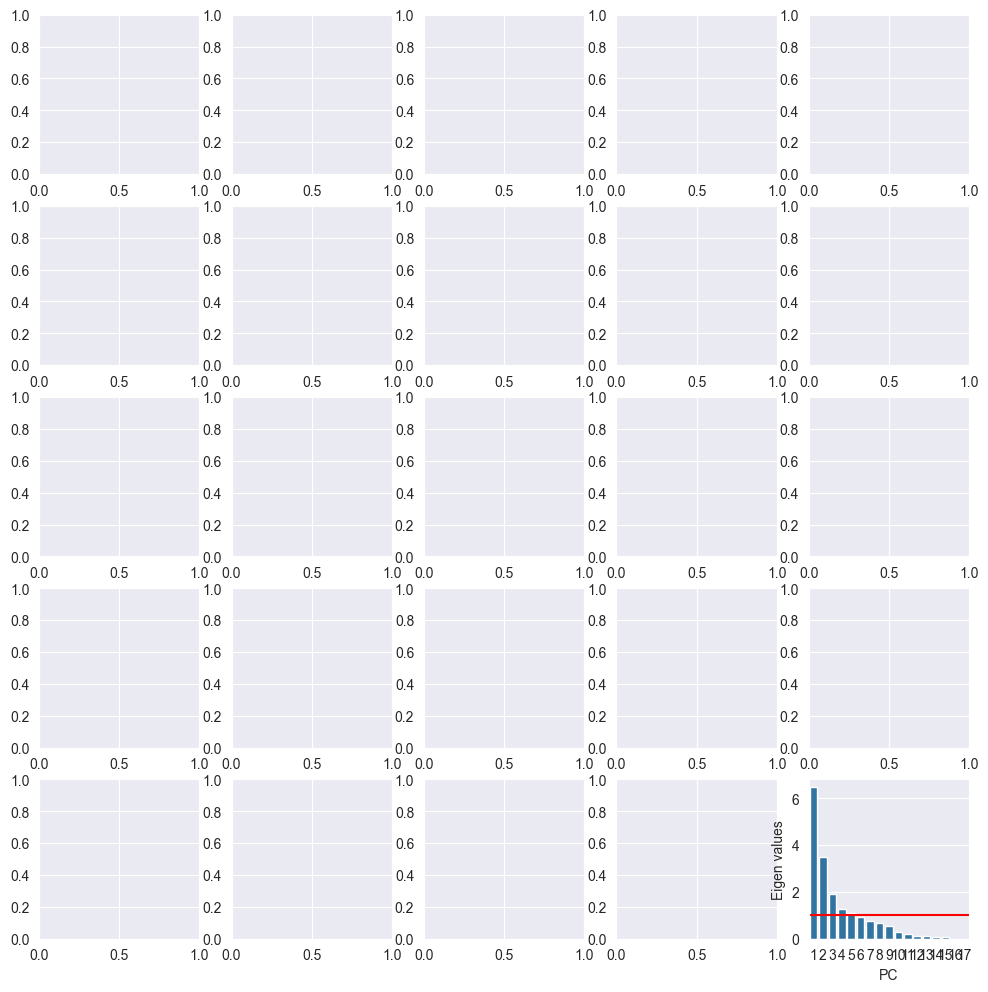

In [9]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
axs = axs.flatten()

sns.barplot(x = range(1, len(eigenvalues_dict['X_2'])+1),y=eigenvalues_dict['X_2'])
plt.ylabel('Eigen values')
plt.xlabel('PC')
plt.axhline(y=1, color='r')
plt.show()

In [10]:
print(X_pca.shape)
X_pca.head()

(174, 115)


,task_1_PC_1,task_1_PC_2,task_1_PC_3,task_1_PC_4,task_1_PC_5,task_2_PC_1,task_2_PC_2,task_2_PC_3,task_2_PC_4,task_2_PC_5,...,task_23_PC_4,task_23_PC_5,task_24_PC_1,task_24_PC_2,task_24_PC_3,task_24_PC_4,task_25_PC_1,task_25_PC_2,task_25_PC_3,task_25_PC_4
0,-2.822564,1.066347,-0.502270,1.512005,-1.505329,2.207812,0.305959,1.303271,-0.297084,0.144150,...,0.780707,-0.541239,0.231137,-1.542468,1.965651,1.196079,1.204851,-1.554284,1.636588,-1.261708
1,-4.415840,2.910133,0.296269,0.369255,2.217803,3.463420,1.194120,0.863193,0.508914,-0.199806,...,-0.286341,-0.845487,-3.745736,-0.750345,0.286422,0.586965,-6.680302,0.282420,0.529999,-1.592043
2,-0.617912,-0.352200,0.135462,0.493668,-0.080069,-1.679897,-0.452618,0.153288,0.026290,-0.549906,...,0.314404,-0.006709,-3.265956,1.038517,1.447714,0.814838,-0.806069,0.117356,-1.386081,1.349985
3,0.510604,0.064401,0.235215,-1.028604,-0.171790,2.356695,-1.103693,-0.164551,-0.886425,-0.316457,...,-0.627569,-0.061997,-3.474620,1.402322,2.433399,0.414838,-2.767879,-0.712425,0.514504,-0.500998
4,-0.811080,-1.728787,0.622613,0.366749,0.258573,-0.382332,-0.717785,0.987443,-0.261193,-0.623538,...,0.072421,-0.188409,-3.801311,2.065559,2.776641,0.654945,-1.701364,-2.011850,-0.022621,0.609275


# Train and test dataset split

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Saving split files
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('X_test.csv', index=False)

(139, 115) (139,)
(35, 115) (35,)


# Metric: recall for class 1 (no healthy)

In [12]:
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import cross_val_score
scorer = make_scorer(recall_score, pos_label=1)

In [13]:
# number of k folds
k_1 = 2
scores_k_1 = []
k_2 = 5
scores_k_2 = []
k_3 = 10
scores_k_3= []

name_classifiers=['RF', 'KNN', 'MLP', 'DT', 'NB', 'LR','SVM', 'Stacked']

## Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=123)

scores = cross_val_score(clf_rf, X, y, cv=k_1, scoring=scorer)
scores_k_1.append(np.mean(scores))

scores = cross_val_score(clf_rf, X, y, cv=k_2, scoring=scorer)
scores_k_2.append(np.mean(scores))

scores = cross_val_score(clf_rf, X, y, cv=k_3, scoring=scorer)
scores_k_3.append(np.mean(scores))

print(np.mean(scores))

0.8277777777777778


## KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=3)

scores = cross_val_score(clf_knn, X, y, cv=k_1, scoring=scorer)
scores_k_1.append(np.mean(scores))

scores = cross_val_score(clf_knn, X, y, cv=k_2, scoring=scorer)
scores_k_2.append(np.mean(scores))

scores = cross_val_score(clf_knn, X, y, cv=k_3, scoring=scorer)
scores_k_3.append(np.mean(scores))

print(np.mean(scores))

0.5347222222222221


## MLP

In [16]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
scores = cross_val_score(clf_mlp, X, y, cv=k_1, scoring=scorer)

scores = cross_val_score(clf_mlp, X, y, cv=k_1, scoring=scorer)
scores_k_1.append(np.mean(scores))

scores = cross_val_score(clf_mlp, X, y, cv=k_2, scoring=scorer)
scores_k_2.append(np.mean(scores))

scores = cross_val_score(clf_mlp, X, y, cv=k_3, scoring=scorer)
scores_k_3.append(np.mean(scores))

print(np.mean(scores))

0.8


## Decision tree

In [17]:
from sklearn.tree import DecisionTreeClassifier
clf_dtree = DecisionTreeClassifier()

scores = cross_val_score(clf_dtree, X, y, cv=k_1, scoring=scorer)
scores_k_1.append(np.mean(scores))

scores = cross_val_score(clf_dtree, X, y, cv=k_1, scoring=scorer)
scores_k_2.append(np.mean(scores))

scores = cross_val_score(clf_dtree, X, y, cv=k_1, scoring=scorer)
scores_k_3.append(np.mean(scores))

print(np.mean(scores))

0.7191919191919192


## NB

In [18]:
from sklearn.naive_bayes import GaussianNB
clf_nb = GaussianNB()

scores = cross_val_score(clf_nb, X, y, cv=k_1, scoring=scorer)
scores_k_1.append(np.mean(scores))

scores = cross_val_score(clf_nb, X, y, cv=k_2, scoring=scorer)
scores_k_2.append(np.mean(scores))

scores = cross_val_score(clf_nb, X, y, cv=k_3, scoring=scorer)
scores_k_3.append(np.mean(scores))

print(np.mean(scores))

0.8875


## LR

In [19]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(max_iter=1000)

scores = cross_val_score(clf_lr, X, y, cv=k_1, scoring=scorer)
scores_k_1.append(np.mean(scores))

scores = cross_val_score(clf_lr, X, y, cv=k_2, scoring=scorer)
scores_k_2.append(np.mean(scores))

scores = cross_val_score(clf_lr, X, y, cv=k_3, scoring=scorer)
scores_k_3.append(np.mean(scores))

print(np.mean(scores))

0.8208333333333334


## SVM

In [20]:
from sklearn.svm import SVC
clf_svm = SVC(kernel='linear')
scores = cross_val_score(clf_svm, X, y, cv=k_1, scoring=scorer)
scores_k_1.append(np.mean(scores))
scores = cross_val_score(clf_svm, X, y, cv=k_2, scoring=scorer)
scores_k_2.append(np.mean(scores))
scores = cross_val_score(clf_svm, X, y, cv=k_3, scoring=scorer)
scores_k_3.append(np.mean(scores))

print(np.mean(scores))

0.798611111111111


## Adaboost (Stacking)

In [21]:
base_learners = [
    ('rf', clf_rf),
    ('knn', clf_knn),
    ('mlp', clf_mlp),
    ('nb', clf_nb),
    ('dt', clf_dtree),
    ('lr', clf_lr),
    ('svm', clf_svm)
]

meta_learners = LogisticRegression()

### Training each base learners

In [22]:
stacked_train_predictions = {}
for t in base_learners:
    t[1].fit(X_train, y_train)
    stacked_train_predictions[t[0]]= t[1].predict(X_train)

predictions = tuple([x for x in stacked_train_predictions.values()])
stacked_predictions_np =  np.column_stack(predictions)

In [23]:
from sklearn.ensemble import AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(estimator=None, n_estimators=50, random_state=123)
adaboost_clf.fit(stacked_predictions_np, y_train)

AdaBoostClassifier(random_state=123)

### Prediction using base learners

In [24]:
stacked_test_predictions = {}
for t in base_learners:
    t[1].fit(X_train, y_train)
    stacked_test_predictions[t[0]]= t[1].predict(X_test)

predictions = tuple([x for x in stacked_test_predictions.values()])
stacked_predictions_np =  np.column_stack(predictions)

In [25]:
y_pred = adaboost_clf.predict(stacked_predictions_np)

In [26]:
scores = cross_val_score(adaboost_clf, X, y, cv=k_1, scoring=scorer)
scores_k_1.append(np.mean(scores))
scores = cross_val_score(adaboost_clf, X, y, cv=k_2, scoring=scorer)
scores_k_2.append(np.mean(scores))
scores = cross_val_score(adaboost_clf, X, y, cv=k_3, scoring=scorer)
scores_k_3.append(np.mean(scores))

print(np.mean(scores))

0.8402777777777779


In [27]:
results_df = pd.DataFrame()
results_df['learner'] = name_classifiers
results_df['k_2'] = scores_k_1
results_df['k_5'] = scores_k_2
results_df['k_10'] = scores_k_3

In [28]:
results_df

,learner,k_2,k_5,k_10
0,RF,0.797475,0.805882,0.827778
1,KNN,0.439899,0.477778,0.534722
2,MLP,0.843434,0.822222,0.800000
3,DT,0.797980,0.707071,0.719192
4,NB,0.932828,0.899346,0.887500
5,LR,0.809596,0.775817,0.820833
6,SVM,0.742677,0.786928,0.798611
7,Stacked,0.696717,0.715686,0.840278


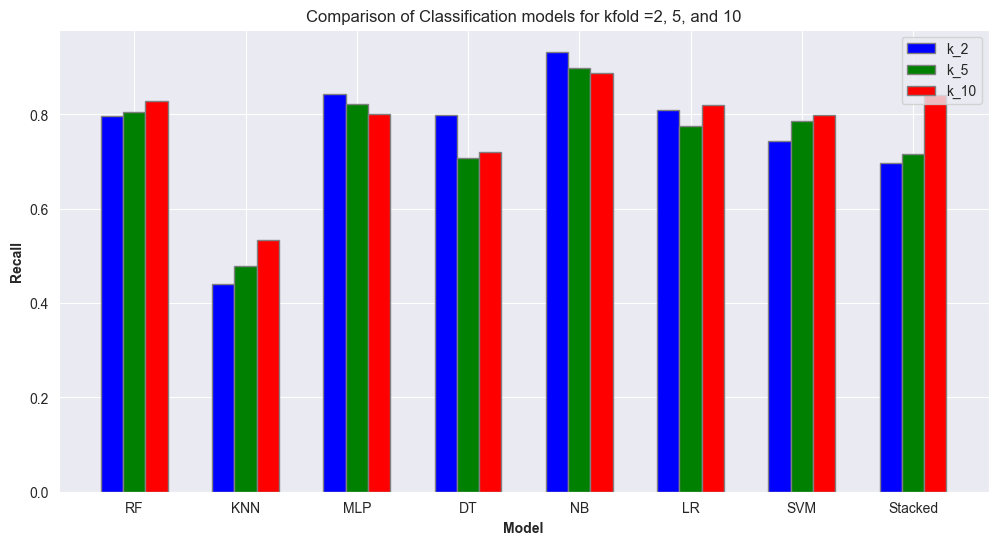

In [29]:
# Plotting the data
plt.figure(figsize=(12, 6))
bar_width = 0.2

# Set position of bar on X axis
r1 = range(len(results_df))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Make the plot
plt.bar(r1, results_df['k_2'], color='b', width=bar_width, edgecolor='grey', label='k_2')
plt.bar(r2, results_df['k_5'], color='g', width=bar_width, edgecolor='grey', label='k_5')
plt.bar(r3, results_df['k_10'], color='r', width=bar_width, edgecolor='grey', label='k_10')

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Recall', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(results_df))], results_df['learner'])

# Create legend & Show graphic
plt.legend()
plt.title('Comparison of Classification models for kfold =2, 5, and 10')
plt.show()